In [1]:
!pip install git+https://github.com/LosVolterrosHermanos/Experimental.git

  Cloning https://github.com/LosVolterrosHermanos/Experimental.git to /tmp/pip-req-build-rs5y8624
  Running command git clone --filter=blob:none --quiet https://github.com/LosVolterrosHermanos/Experimental.git /tmp/pip-req-build-rs5y8624
  Resolved https://github.com/LosVolterrosHermanos/Experimental.git to commit 635f9c89af8fc1404e741fb956ff61d97d04c02d
  Preparing metadata (setup.py) ... done
  Created wheel for power_law_rf: filename=power_law_rf-0.1.0-py3-none-any.whl size=14643 sha256=05d7b6664ab9cb5b0e975f436283ad915ab2dac4e5af3ba974790bf9b6b1e4c3
  Stored in directory: /tmp/pip-ephem-wheel-cache-471t5pvk/wheels/83/5c/ad/54ea86dd5918192bbeeb35964fd68597faf8e33c5c389f89f4
Successfully built power_law_rf


In [2]:
from power_law_rf.deterministic_equivalent import theory_limit_loss, theory_lambda_min, deterministic_rho_weights, theory_rhos
from power_law_rf.ode import ODEInputs, DanaHparams, ode_resolvent_log_implicit

In [11]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def get_optim_hparams(optim_name, alpha, beta, batch_size, D, traceK=None):
  if traceK is None:
    V = 4 * D
    traceK = np.sum(
        np.arange(1, V + 1, dtype=np.float32) ** (-2 * alpha)
    ).item()
  gamma2_mult = 0.375
  gamma2 = gamma2_mult * min(2.0 / (batch_size + 1), 1.0 / traceK)
  dana_delta = (
      max(2.0 + (2.0 * beta - 1) / alpha, 2.0 - 1.0 / alpha) + 1.0
  )
  if optim_name == "dana_sgd":
    return {
        "dana.gamma1": 0.0,
        "dana.gamma2_mult": gamma2_mult,
        "dana.gamma2": gamma2,
        "dana.gamma3": 0.0,
        "dana.gamma3_decay_exp": 0.0,
        "dana.delta": 0.0,
        "dana.delta_decay_exp": 0.0,
        "dana.optimizer_name": "dana_sgd",
    }
  elif optim_name == "dana_constant":
    return {
        "dana.gamma1": 1.0,
        "dana.gamma2_mult": gamma2_mult,
        "dana.gamma2": gamma2,
        "dana.gamma3": 0.1 / (D * traceK),
        "dana.gamma3_decay_exp": 0.0,  # no learning rate decay
        "dana.delta": dana_delta,
        "dana.delta_decay_exp": 1.0,
        "dana.optimizer_name": "dana_constant",
    }
  elif optim_name == "dana_decay":
    return {
        "dana.gamma1": 1.0,
        "dana.gamma2_mult": gamma2_mult,
        "dana.gamma2": gamma2,
        "dana.gamma3": 0.1,
        "dana.gamma3_decay_exp": 1.0 / (2.0 * alpha),  # no learning rate decay
        "dana.delta": dana_delta,
        "dana.delta_decay_exp": 1.0,
        "dana.optimizer_name": "dana_decay",
    }
  else:
    raise ValueError(f"Unknown optimizer: {optim_name}")

In [4]:
def get_dana_hparams(optim, alpha, beta, D, V):
  hparams = get_optim_hparams(optim, alpha, beta, 1, D)
  g1, g2, g3 = hparams['dana.gamma1'], hparams['dana.gamma2'], hparams['dana.gamma3']
  g3_decay_exp = hparams['dana.gamma3_decay_exp']
  delta, delta_decay_exp = hparams['dana.delta'], hparams['dana.delta_decay_exp']
  if delta_decay_exp == 0:
    delta_fn = lambda count: delta
  else:
    delta_fn = lambda count: delta / ((count + 1) ** delta_decay_exp)
  if g3_decay_exp == 0:  # dana constant
    gamma3_fn = lambda count: g3
  else:  # dana decay
    gamma3_fn = lambda count: g3 / ((count + 1) ** g3_decay_exp)

  dana_hparams = DanaHparams(lambda count: g1, lambda count: g2, gamma3_fn, delta_fn)
  return dana_hparams

In [5]:
def theory_ode_inputs(alpha, beta, D, V):
  fake_eigs, rho_init = theory_rhos(alpha, beta, D)
  riskInftyTheory = theory_limit_loss(alpha, beta,V,D)
  num_grid_points = D
  chi_init = jnp.zeros(num_grid_points, dtype=jnp.float64)
  sigma_init = jnp.zeros(num_grid_points, dtype=jnp.float64)
  return ODEInputs(
      fake_eigs.astype(jnp.float64),
      rho_init.astype(jnp.float64),
      chi_init,
      sigma_init,
      riskInftyTheory.astype(jnp.float64),
  )

In [6]:
def get_experiment_steps(alpha, D, flops = 10**12):
  minimum_steps = 1_000_000
  convergence_steps = int(20 * D ** (2 * alpha))
  flops_steps = int(flops / D)
  num_steps = max(min(convergence_steps, flops_steps), minimum_steps)
  return num_steps

In [7]:
def run_ode(alpha, beta, D, V, optim, ode_input_type = 'theory', ode_inputs = None, sgd_batch = 1, ode_flops = None, Dt = 10 ** -2):
  if ode_inputs is None:
    if ode_input_type == 'theory':
      ode_inputs = theory_ode_inputs(alpha, beta, D, V)
    else:
      raise ValueError(f'Unknown ode_input_type: {ode_input_type}')
  hparams = get_dana_hparams(optim, alpha, beta, D, V)
  if ode_flops is None:
    ode_steps = get_experiment_steps(alpha, D)
  else:
    ode_steps = ode_flops // D
  ode_times, ode_risks = ode_resolvent_log_implicit(ode_inputs, hparams, sgd_batch, D, ode_steps, Dt)
  if ode_risks[-1] > 10:
    print('Numerical instability in ODE risks.')
  return ode_times, ode_risks

In [17]:
alpha = 0.7
beta = 0.8
D = 800
V = 4 * D
batch = 1

In [18]:
ode_times, ode_risks = run_ode(alpha, beta, D, V, 'dana_constant')

<ipython-input-5-f2e8c65670ee>:5: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  chi_init = jnp.zeros(num_grid_points, dtype=jnp.float64)
<ipython-input-5-f2e8c65670ee>:6: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  sigma_init = jnp.zeros(num_grid_points, dtype=jnp.float64)
/usr/local/lib/python3.11/dist-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is 

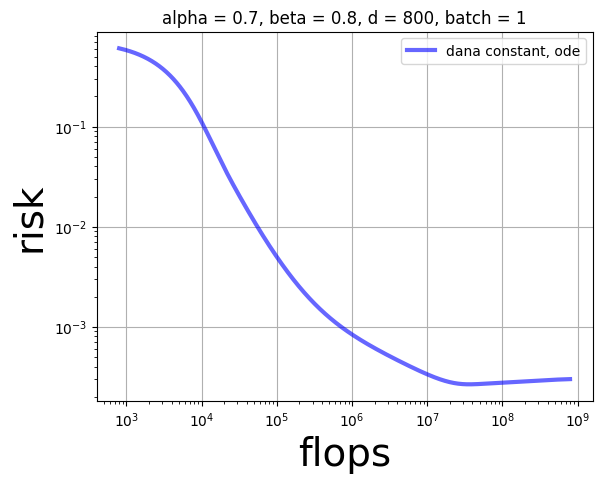

In [20]:
axarr = plt.axes()
axarr.set_xlabel("flops", fontsize = '28')
axarr.set_ylabel("risk", fontsize = '28')
plt.title('alpha = {:,},'.format(alpha)+' beta = {:,}'.format(beta)+', d = {:,}'.format(D)+', batch = {:,}'.format(batch))

plt.plot((ode_times) * (float(D)),ode_risks, label= 'dana constant, ode', linewidth = 3.0, c = 'blue', alpha = 0.6)

plt.yscale('log')
plt.xscale('log')
plt.grid()

leg = plt.legend(loc='upper right', fontsize='10')

f_path = '/tmp/sgd_run.pdf'
plt.savefig(f_path, dpi=500, bbox_inches = 'tight', transparent=True)